## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

## Payoffs and Stationary Distribution

In [2]:
def calc_metrics_custom(p, q, b1, b2, c, eps, rule):
    # Apply implementation error (noise) to the strategies
    p_eff = p * (1 - 2 * eps) + eps
    q_eff = q * (1 - 2 * eps) + eps
    
    M = np.zeros((8, 8))
    # Mapping for opponent's previous move indices
    opp_idx = {0: 0, 1: 2, 2: 1, 3: 3} 
    
    for s in range(8):
        env_idx = s // 4
        c1 = p_eff[s]
        c2 = q_eff[env_idx * 4 + opp_idx[s % 4]]
        # Joint probabilities: [CC, CD, DC, DD]
        probs = [c1 * c2, c1 * (1 - c2), (1 - c1) * c2, (1 - c1) * (1 - c2)]
        
        for act, prob in enumerate(probs):
            # Transition rule logic: [CC_dest, Mix_dest, DD_dest]
            # Environment Code: 0 = Good, 1 = Bad
            if act == 0: next_env = rule[0]      # Mutual Cooperation
            elif act == 3: next_env = rule[2]    # Mutual Defection
            else: next_env = rule[1]             # Mixed (CD or DC)
            
            M[s, next_env * 4 + act] = prob

    # Calculate stationary distribution via eigenvectors
    vals, vecs = np.linalg.eig(M.T)
    idx = np.argmin(np.abs(vals - 1.0))
    v = np.abs(vecs[:, idx].real)
    v /= v.sum()
    
    # Calculate metrics
    coop_rate = np.dot(v, p_eff)
    time_in_s1 = np.sum(v[:4]) 
    
    # Payoff matrices
    u1 = np.array([b1 - c, -c, b1, 0])
    u2 = np.array([b2 - c, -c, b2, 0])
    pi_p = np.dot(v[:4], u1) + np.dot(v[4:], u2)
    
    u1_m = np.array([b1 - c, b1, -c, 0])
    u2_m = np.array([b2 - c, b2, -c, 0])
    pi_q = np.dot(v[:4], u1_m) + np.dot(v[4:], u2_m)
    
    return pi_p, pi_q, coop_rate, time_in_s1

# Fixation Probability (Fermi process / Traulsen's formula)
def get_fixation_probability(pi_m, pi_r, pi_mm, pi_rm, n_pop, beta):
    diffs = []
    for j in range(1, n_pop):
        f_m = ((j - 1) * pi_mm + (n_pop - j) * pi_m) / (n_pop - 1)
        f_r = (j * pi_rm + (n_pop - j - 1) * pi_r) / (n_pop - 1)
        diffs.append(f_r - f_m)
    
    exponent_sums = np.cumsum(beta * np.array(diffs))
    # Clip values to prevent numerical overflow
    return 1.0 / (1.0 + np.sum(np.exp(np.clip(exponent_sums, -200, 200))))

## Simulation Runner

In [3]:
def run_simulation_full(args):
    idx, label, code_rule = args
    
    # --- Simulation Parameters ---
    # Payoff parameters
    b1 = 2.0 
    b2, c = 1.2, 1.0
    
    # Selection intensity
    beta = 100
    
    # Noise and Population
    eps = 0.001
    N = 100
    steps = 5000
    
    # Initialize resident strategy (AllD or random)
    res_strat = np.zeros(8)
    
    steady_start = int(steps * 0.5)
    avg_coop = 0.0
    avg_time_s1 = 0.0
    
    for t in range(steps):
        # Generate mutant strategy (Random binary)
        mut_strat = np.random.randint(0, 2, 8).astype(np.float64)
        
        pi_rr, _, _, _ = calc_metrics_custom(res_strat, res_strat, b1, b2, c, eps, code_rule)
        pi_rm, pi_mr, _, _ = calc_metrics_custom(res_strat, mut_strat, b1, b2, c, eps, code_rule)
        pi_mm, _, _, _ = calc_metrics_custom(mut_strat, mut_strat, b1, b2, c, eps, code_rule)
        
        p_fix = get_fixation_probability(pi_mr, pi_rr, pi_mm, pi_rm, N, beta)
        
        # Evolutionary update step
        if np.random.rand() < p_fix:
            res_strat = mut_strat
            
        # Data collection (steady state)
        if t >= steady_start:
            _, _, c_r, t_s1 = calc_metrics_custom(res_strat, res_strat, b1, b2, c, eps, code_rule)
            avg_coop += c_r
            avg_time_s1 += t_s1
            
    count = steps - steady_start
    return idx, avg_coop / count, avg_time_s1 / count

## Main

Generating Fig 2


100%|██████████| 800/800 [18:59<00:00,  1.42s/it]


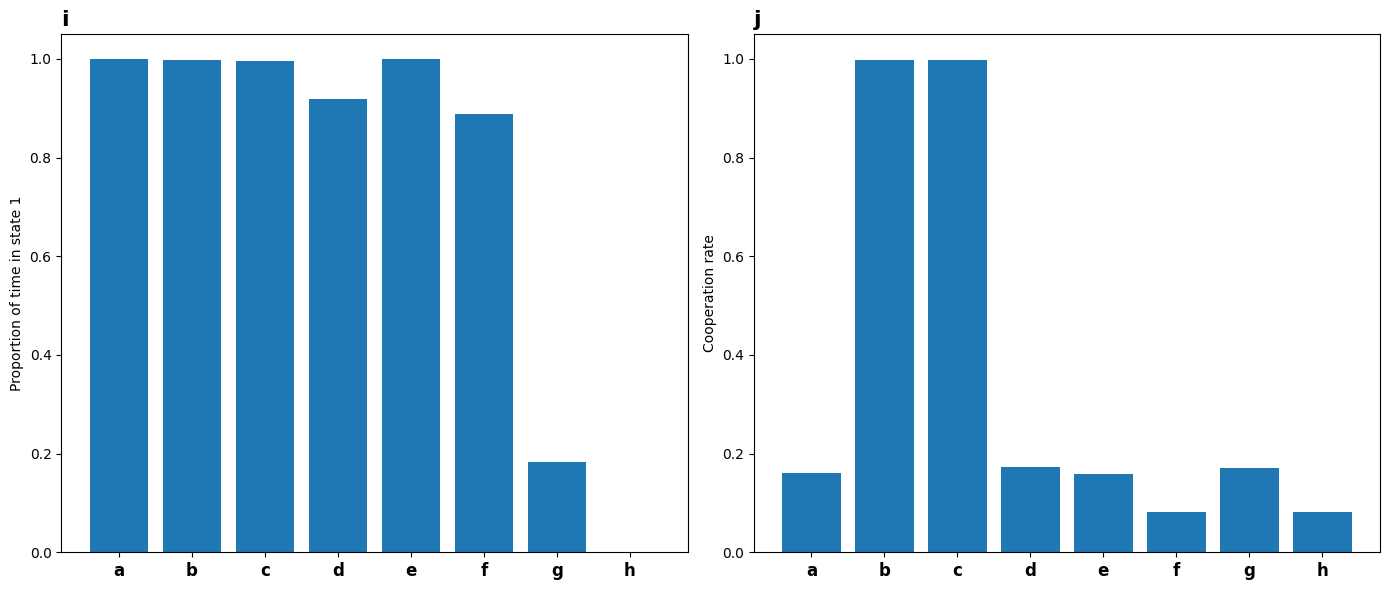

In [4]:
if __name__ == '__main__':
    print("Generating Fig 2")
    
    # Define transition rules (mapping labels a-h to binary logic)
    # The list defines the logic for Environmental Feedback
    ordered_rules = [
        ('a', [1, 1, 1]), # a
        ('b', [1, 0, 1]), # b
        ('c', [1, 0, 0]), # c
        ('d', [0, 1, 1]), # d
        ('e', [1, 1, 1]), # e
        ('f', [0, 0, 1]), # f
        ('g', [0, 1, 0]), # g
        ('h', [0, 0, 0]), # h
    ]
    
    tasks = []
    RUNS = 100 # Number of independent runs for averaging
    
    for idx, (label, paper_rule) in enumerate(ordered_rules):
        # Convert paper rule format to code logic (if necessary invert logic)
        code_rule = [1 - x for x in paper_rule]
        for _ in range(RUNS):
            tasks.append((idx, label, code_rule))
            
    results = [run_simulation_full(t) for t in tqdm(tasks)]
        
    coop_data = np.zeros(8)
    time_s1_data = np.zeros(8)
    counts = np.zeros(8)
    
    for idx, c_r, t_s1 in results:
        coop_data[idx] += c_r
        time_s1_data[idx] += t_s1
        counts[idx] += 1
        
    coop_data /= counts
    time_s1_data /= counts
    
    # Plotting results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    x = range(8)
    labels = [r[0] for r in ordered_rules]
    
    # Subplot i: Time in State 1
    ax1.bar(x, time_s1_data)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, fontsize=12, fontweight='bold')
    ax1.set_ylabel('Proportion of time in state 1')
    ax1.set_title('i', loc='left', fontweight='bold', fontsize=16)
    ax1.set_ylim(0, 1.05)
    
    # Subplot j: Cooperation Rate
    ax2.bar(x, coop_data)
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, fontsize=12, fontweight='bold')
    ax2.set_ylabel('Cooperation rate')
    ax2.set_title('j', loc='left', fontweight='bold', fontsize=16)
    ax2.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.show()